# Modelado de curvas de polarización que no exhiben una región de Tafel

## Librerias a utilizar

In [1]:
from openpyxl import load_workbook as hoja_calculo
import numpy as np
import math as matematica
from matplotlib import pyplot as graficadorCaceres
from matplotlib import pyplot as graficadorBeta
from matplotlib import pyplot as graficadorMaclaurin
from matplotlib import pyplot as graficador3modelos
import pandas as pd
import scipy.optimize as optimization
import os
import shutil

## Nombre del archivo Excel de donde se cargaran los datos

## Ingrese el directorio donde se encuentra el archivo que va a cargar
```
La ruta debe finalizar con el caracter "/"
```
```
Si el archivo se encuentra en el mismo directorio que el ipython notebook, debe quedar rutaDatosOrigen = ""
```


In [2]:
rutaDatosOrigen = "C:/Users/PC/Documents/Espacio de Trabajo/RatioCorrosion/RC_Jupyter/Archivos/"

### Ingrese el nombre del archivo desde donde se cargaran los datos (sin la extension)

In [3]:
nombreArchivo = "datos2Arreglado"

In [4]:
archivo = hoja_calculo( rutaDatosOrigen + nombreArchivo + ".xlsx", read_only=True)
hoja = archivo.worksheets[0]

listaVoltaje = []
listaAmperaje = []

## Creacion carpeta donde se guardaran los resultados

In [5]:
if( os.path.exists(nombreArchivo) ) :
    shutil.rmtree(nombreArchivo)
if( os.path.exists(nombreArchivo) == False ) :
    os.mkdir(nombreArchivo)

## Lectura de datos

In [6]:
for fila in hoja.iter_rows():
    if (isinstance(fila[0].value, int) or isinstance(fila[0].value, float)) and (isinstance(fila[2].value, int) or isinstance(fila[2].value, float)):
        listaVoltaje.append(fila[0].value)
        listaAmperaje.append(fila[2].value)

## Calculo Voltaje y Amperaje 

In [7]:
#areaExpuesta = 2.5133 
areaExpuesta = 0.1257
#areaExpuesta = 1

In [8]:
eVAgCl = np.array(listaVoltaje, float)
iAexp = np.array(listaAmperaje, float)
eVSHE = eVAgCl + 0.237
iAAcm2exp = iAexp /areaExpuesta

## Calculo Experimental

In [9]:
absiAexp = np.absolute(iAAcm2exp)
logABSiAexp = np.log10(absiAexp)

# Ajuste Modelo De Caceres 
$$ $$
$$ $$
$$i_{t} = \frac{-i_{o,O2} exp-2.3(\frac{E-E_{eq,O2}}{tc})}{1+(\frac{i_{o,O2}}{i_{l,O2}}) exp-2.3(\frac{E-E_{eq,O2}}{tc})} + i_{o,Fe} exp2.3(\frac{E-E_{eq,Fe}}{ta})$$

## Función Objetivo 

In [10]:
def caceres(eVSHE, io, iL, iFe, tc, ta):  
    modeloCatodicoA = -io*(np.exp(-2.3*(eVSHE-0.762)/tc))
    modeloCatodicoB = 1+((io/iL)*(np.exp(-2.3*(eVSHE-0.762)/tc)))
    modeloCatodicoAdivididoB = modeloCatodicoA / modeloCatodicoB
    modeloAnodo = iFe*(np.exp(2.3*(eVSHE+ 0.614)/ta))
    iAAcm2fit = modeloCatodicoAdivididoB + modeloAnodo   
    return(iAAcm2fit)

## Restricciones de los coeficientes 
Debe definir los limites inferior y superior de cada variable en el siguiente orden:
$$[ \hspace{0.3cm} i_{o,O2} ,\hspace{0.3cm} i_{l,O2} , \hspace{0.3cm} i_{o,Fe} , \hspace{0.3cm} tc , \hspace{0.3cm} ta \hspace{0.3cm} ]$$

In [11]:
limiteInferiorCaceres = [0.0001,0.5,0.00001,0.1,0.18]
limiteSuperiorCaceres = [0.1,1,1,3,1]

## Calculo del modelo

In [12]:
valoresAjustadosCaceres, pcov1 =optimization.curve_fit(caceres, eVSHE, iAAcm2exp,bounds=(limiteInferiorCaceres,limiteSuperiorCaceres),method='trf')

## Calculo del Logaritmo

In [13]:
valoresModeloCaceresFit = caceres(eVSHE, *valoresAjustadosCaceres)
valoresAbsolutosModeloCaceres = np.absolute(valoresModeloCaceresFit)
valoresLogaritmoModeloCaceres = np.log10(valoresAbsolutosModeloCaceres)
valoresModeloCaceresLog = np.asarray(valoresLogaritmoModeloCaceres)

# Ajuste Modelo Beta
$$ $$
$$ $$
$$C_{1} = 2.303 i_{corr}({(\frac{1}{b_{a}})+(\frac{1}{b_{c}})(1-\beta)})$$
$$ $$
$$2C_{2} = 5.303 i_{corr}({(\frac{1}{b_{a}})^2-(\frac{1}{b_{c}})^2(1+3\beta-2\beta^2)})$$
$$ $$
$$6C_{3} = 12.214 i_{corr}({(\frac{1}{b_{a}})^3+(\frac{1}{b_{c}})^3(1-7\beta+12\beta^2-6\beta^3)})$$
$$ $$
$$24C_{4} = 28.13 i_{corr}({(\frac{1}{b_{a}})^4-(\frac{1}{b_{c}})^4(1+15\beta-50\beta^2+60\beta^3-24\beta^4)})$$

## Función Objetivo 

In [14]:
def beta(eVSHE, icorr, Ecorr, ba, Beta, bc):  
    c1 = 2.3*icorr*((1/ba)+(1/bc)*(1-Beta))
    c2 = (5.303/2)*icorr*(matematica.pow((1/ba),2)-matematica.pow((1/bc),2)*(1+(3*Beta)-(2*matematica.pow(Beta,2))))
    c3 = (12.214/6)*icorr*(matematica.pow((1/ba),3)+matematica.pow((1/bc),3)*(1-(7*Beta)+(12*matematica.pow(Beta,2))-(6*matematica.pow(Beta,3))))                        
    c4 = (28.13/24)*icorr*(matematica.pow((1/ba),4)-(matematica.pow((1/bc),4))*(1+(15*Beta)-(50*matematica.pow(Beta,2))+(60*matematica.pow(Beta,3))-(24*matematica.pow(Beta,4))))
    iFit = (c1*(eVSHE-Ecorr))+(c2*np.power((eVSHE-Ecorr),2))+(c3*np.power((eVSHE-Ecorr),3))+(c4*np.power((eVSHE-Ecorr),4))
    return(iFit)    

## Restricciones de los coeficientes
Debe definir los limites inferior y superior de cada variable en el siguiente orden:
$$[ \hspace{0.3cm} i_{corr} ,\hspace{0.3cm} E_{corr} , \hspace{0.3cm} ba , \hspace{0.3cm} \beta, \hspace{0.3cm} bc \hspace{0.3cm} ]$$

In [15]:
limiteInferiorBeta = [0.1,-0.250,0.00001,0.04,0.18]
limiteSuperiorBeta = [3,-0.218,1,0.75,1]

## Calculo del modelo 

In [16]:
valoresAjustadosBeta, pcov2 =optimization.curve_fit(beta, eVSHE, iAAcm2exp,bounds=(limiteInferiorBeta,limiteSuperiorBeta),method='trf')

## Calculo del Logaritmo

In [17]:
valoresModeloBetaFit = beta(eVSHE, *valoresAjustadosBeta)
valoresAbsolutosModeloBeta = np.absolute(valoresModeloBetaFit)
valoresLogaritmoModeloBeta = np.log10(valoresAbsolutosModeloBeta)
valoresModeloBetaLog = np.asarray(valoresLogaritmoModeloBeta)

# Ajuste Modelo Maclaurin

## Función Objetivo 
$$ $$
$$ $$
$$C_{0} = 0$$
$$ $$
$$C_{1} = a_{1}\lbrace a_{2}+a_{3}(1-\beta)\rbrace$$
$$ $$
$$C_{2} = a_{1}\lbrace a_{2}^2-a_{3}^2(1-3\beta+2\beta^2)\rbrace$$
$$ $$
$$C_{3} = a_{1}\lbrace a_{2}^3-a_{3}^3(1-7\beta+12\beta^2-6\beta^3) \rbrace$$
$$ $$
$$C_{4} = a_{1}\lbrace a_{2}^4-a_{3}^4(1-15\beta+50\beta^2-60\beta^3+24\beta^4) \rbrace$$

In [18]:
def maclaurin(eVSHE, icorr, Ecorr, ba, Beta, bc):  
    c1=2.3*icorr*((1/ba)+(1/bc)*(1-Beta))
    c2=(5.303/2)*icorr*(matematica.pow((1/ba),2)-matematica.pow((1/bc),2)*(1-(3*Beta)+(2*matematica.pow(Beta,2))))
    c3=(12.214/6)*icorr*(matematica.pow((1/ba),3)+matematica.pow((1/bc),3)*(1-(7*Beta)+(12*matematica.pow(Beta,2))-(6*matematica.pow(Beta,3))))                        
    c4=(28.13/24)*icorr*(matematica.pow((1/ba),4)-(matematica.pow((1/bc),4))*(1-(15*Beta)+(50*matematica.pow(Beta,2))-(60*matematica.pow(Beta,3))+(24*matematica.pow(Beta,4))))
    iFit=(c1*(eVSHE-Ecorr))+(c2*np.power((eVSHE-Ecorr),2))+(c3*np.power((eVSHE-Ecorr),3))+(c4*np.power((eVSHE-Ecorr),4))
    return(iFit)  

## Restricciones de los coeficientes
Debe definir los limites inferior y superior de cada variable en el siguiente orden:
$$[ \hspace{0.3cm} i_{corr} ,\hspace{0.3cm} E_{corr} , \hspace{0.3cm} ba , \hspace{0.3cm} \beta, \hspace{0.3cm} bc \hspace{0.3cm} ]$$

In [19]:
limiteInferiorMaclaurin = [0.0187,-0.244,0.00001,0.04,0.18]
limiteSuperiorMaclaurin = [3,-0.218,1,0.75,1]

## Calculo del modelo

In [20]:
valoresAjustadosMaclaurin, pcov =optimization.curve_fit(maclaurin, eVSHE, iAAcm2exp,bounds=(limiteInferiorMaclaurin,limiteSuperiorMaclaurin),method='trf')

## Calculo del Logaritmo 

In [21]:
valoresModeloMaclaurinFit = maclaurin(eVSHE, *valoresAjustadosMaclaurin)
valoresAbsolutosModeloMaclaurin = np.absolute(valoresModeloMaclaurinFit)
valoresLogaritmoModeloMaclaurin = np.log10(valoresAbsolutosModeloMaclaurin)
valoresModeloMaclaurinLog = np.asarray(valoresLogaritmoModeloMaclaurin)

## Graficos De Los Datos Experimentales y Datos De Los Modelos  

In [22]:
datosExperimentales= np.asarray(logABSiAexp)

### Grafico Modelo Caceres

In [23]:
def graficoCaceres(datosExperimentales,eVSHE,valoresModeloCaceresLog,nombreArchivo):
    graficadorCaceres.figure(figsize=(20,11))
    graficadorCaceres.plot(datosExperimentales, eVSHE, 'r+', label='Experimental')
    graficadorCaceres.plot(valoresModeloCaceresLog,eVSHE , 'b-', label='Modelo Caceres')
    graficadorCaceres.xlabel('Log (i/A) A cm-2')
    graficadorCaceres.ylabel('E(Evs.SHE)')
    graficadorCaceres.title("Grafico Modelo Caceres " + nombreArchivo)
    graficadorCaceres.legend()
    graficadorCaceres.savefig( nombreArchivo + "/" + nombreArchivo + '-grafico-modelo-caceres.png', dpi = 300)
    graficadorCaceres.show()
    #return()

### Grafico Modelo Beta

In [24]:
def graficoBeta(datosExperimentales,eVSHE,valoresModeloBetaLog,nombreArchivo):
    graficadorBeta.figure(figsize=(20,11))
    graficadorBeta.plot(datosExperimentales, eVSHE, 'r+', label='Experimental')
    graficadorBeta.plot(valoresModeloBetaLog,eVSHE , 'g-', label='Modelo Beta')
    graficadorBeta.xlabel('Log (i/A) A cm-2')
    graficadorBeta.ylabel('E(Evs.SHE)')
    graficadorBeta.title("Grafico Modelo Beta " + nombreArchivo)
    graficadorBeta.legend()
    graficadorBeta.savefig( nombreArchivo + "/" + nombreArchivo + '-grafico-modelo-beta.png', dpi = 300)
    graficadorBeta.show()

### Grafico Modelo Maclaurin

In [25]:
def graficoMaclaurin(datosExperimentales,eVSHE,valoresModeloMaclaurinLog,nombreArchivo):
    graficadorMaclaurin.figure(figsize=(20,11))
    graficadorMaclaurin.plot(datosExperimentales, eVSHE, 'r+', label='Experimental')
    graficadorMaclaurin.plot(valoresModeloMaclaurinLog,eVSHE , 'y-', label='Modelo Maclaurin')
    graficadorMaclaurin.xlabel('Log (i/A) A cm-2')
    graficadorMaclaurin.ylabel('E(Evs.SHE)')
    graficadorMaclaurin.title("Grafico Modelo Maclaurin " + nombreArchivo)
    graficadorMaclaurin.legend()
    graficadorMaclaurin.savefig( nombreArchivo + "/" + nombreArchivo + '-grafico-modelo-maclaurin.png', dpi = 300)
    graficadorMaclaurin.show()

### Grafico Modelo Caceres, Beta y Maclaurin

In [26]:
def grafico3modelos(datosExperimentales,eVSHE,valoresModeloCaceresLog,valoresModeloBetaLog,valoresModeloMaclaurinLog,nombreArchivo):
    graficador3modelos.figure(figsize=(20,11))
    graficador3modelos.plot(datosExperimentales, eVSHE, 'r-', label='Experimental')
    graficador3modelos.plot(valoresModeloCaceresLog,eVSHE , 'b+', label='Modelo Caceres')
    graficador3modelos.plot(valoresModeloBetaLog,eVSHE , 'g+', label='Modelo Beta')
    graficador3modelos.plot(valoresModeloMaclaurinLog,eVSHE , 'y+', label='Modelo Maclaurin')
    graficador3modelos.xlabel('Log (i/A) A cm-2')
    graficador3modelos.ylabel('E(Evs.SHE)')
    graficador3modelos.title('Grafico 3 Modelos ' + nombreArchivo)
    graficador3modelos.legend()
    graficador3modelos.savefig( nombreArchivo + "/" + nombreArchivo + '-grafico3modelos.png', dpi = 300)
    graficador3modelos.show()

# Resultados Finales

## Coeficientes Optimizados Modelo Caceres

In [27]:
ioOptimo = valoresAjustadosCaceres[0]
iLOptimo = valoresAjustadosCaceres[1]
iFeOptimo= valoresAjustadosCaceres[2]
tcOptimo       = valoresAjustadosCaceres[3]
taOptimo       = valoresAjustadosCaceres[4]

## Coeficientes Optmizados Modelo Beta 

In [28]:
iCorrOptimoBeta = valoresAjustadosBeta[0]
EcorrOptimoBeta = valoresAjustadosBeta[1]
baOptimoBeta    = valoresAjustadosBeta[2]
BetaOptimoBeta  = valoresAjustadosBeta[3]
bcOptimoBeta    = valoresAjustadosBeta[4]

## Coeficientes Optimizados Modelo Maclaurin

In [29]:
iCorrOptimoMaclaurin = valoresAjustadosMaclaurin[0]
EcorrOptimoMaclaurin = valoresAjustadosMaclaurin[1]
baOptimoMaclaurin    = valoresAjustadosMaclaurin[2]
BetaOptimoMaclaurin  = valoresAjustadosMaclaurin[3]
bcOptimoMaclaurin    = valoresAjustadosMaclaurin[4]

# Estadigrafos

## Modelo De Caceres 

In [30]:
PromedioDeY = np.mean(iAAcm2exp)
DF = iAAcm2exp.size - 3
S  = np.std(valoresModeloCaceresFit, dtype=np.float64)
ExtremosiAAcm2exp  = iAAcm2exp[0]-iAAcm2exp[iAAcm2exp.size-1]

sumatoriaDiferenciaExtremosExpFit = np.sum(np.power(ExtremosiAAcm2exp-valoresModeloCaceresFit,2))
SEofY = matematica.sqrt(sumatoriaDiferenciaExtremosExpFit/DF)

restaValores = (iAAcm2exp-valoresModeloCaceresFit)
cuadrado =np.power(restaValores,2)
sumatoriaExpMenosFit = np.sum(cuadrado)

restaPromedio = (iAAcm2exp-PromedioDeY)
cuadradoResta = np.power(restaPromedio,2)
iAAcm2expMenosPromY  =  np.sum(cuadradoResta)

R2 = 1-(sumatoriaExpMenosFit/iAAcm2expMenosPromY)

SSE = SEofY/18
RMSE = matematica.sqrt(SEofY)

diferenciaFitExp = iAAcm2exp-valoresModeloCaceresFit
diferenciaElevada = np.power(diferenciaFitExp,2)
SS = diferenciaElevada/matematica.pow(S,2)
sumatoriaSS = np.sum(SS)

ChiCuadrado = sumatoriaSS/DF

## Modelo Beta 

In [31]:
PromedioDeY = np.mean(iAAcm2exp)
DF = iAAcm2exp.size - 3
SBeta  = np.std(valoresModeloBetaFit, dtype=np.float64)
ExtremosiAAcm2exp  = iAAcm2exp[0]-iAAcm2exp[iAAcm2exp.size-1]

sumatoriaDiferenciaExtremosExpFitBeta = np.sum(np.power(ExtremosiAAcm2exp-valoresModeloBetaFit,2))
SEofYBeta = matematica.sqrt(sumatoriaDiferenciaExtremosExpFitBeta/DF)

restaValoresBeta = (iAAcm2exp-valoresModeloBetaFit)
cuadradoBeta =np.power(restaValoresBeta,2)
sumatoriaExpMenosFitBeta = np.sum(cuadradoBeta)

restaPromedio = (iAAcm2exp-PromedioDeY)
cuadradoResta = np.power(restaPromedio,2)
iAAcm2expMenosPromY  =  np.sum(cuadradoResta)

R2Beta = 1-(sumatoriaExpMenosFitBeta/iAAcm2expMenosPromY)

SSEBeta = SEofYBeta/18
RMSEBeta = matematica.sqrt(SEofYBeta)

diferenciaFitExpBeta = iAAcm2exp-valoresModeloBetaFit
diferenciaElevadaBeta = np.power(diferenciaFitExpBeta,2)
SSBeta = diferenciaElevadaBeta/matematica.pow(SBeta,2)
sumatoriaSSBeta = np.sum(SSBeta)

ChiCuadradoBeta = sumatoriaSSBeta/DF

## Modelo Maclaurin 

In [32]:
PromedioDeY = np.mean(iAAcm2exp)
DF = iAAcm2exp.size - 3
SMaclaurin  = np.std(valoresModeloMaclaurinFit, dtype=np.float64)
ExtremosiAAcm2exp  = iAAcm2exp[0]-iAAcm2exp[iAAcm2exp.size-1]

sumatoriaDiferenciaExtremosExpFitMaclaurin = np.sum(np.power(ExtremosiAAcm2exp-valoresModeloMaclaurinFit,2))
SEofYMaclaurin = matematica.sqrt(sumatoriaDiferenciaExtremosExpFitMaclaurin/DF)

restaValoresMaclaurin = (iAAcm2exp-valoresModeloMaclaurinFit)
cuadradoMaclaurin =np.power(restaValoresMaclaurin,2)
sumatoriaExpMenosFitMaclaurin = np.sum(cuadradoMaclaurin)

restaPromedio = (iAAcm2exp-PromedioDeY)
cuadradoResta = np.power(restaPromedio,2)
iAAcm2expMenosPromY  =  np.sum(cuadradoResta)

R2Maclaurin = 1-(sumatoriaExpMenosFitMaclaurin/iAAcm2expMenosPromY)

SSEMaclaurin = SEofYMaclaurin/18
RMSEMaclaurin = matematica.sqrt(SEofYMaclaurin)

diferenciaFitExpMaclaurin = iAAcm2exp-valoresModeloMaclaurinFit
diferenciaElevadaMaclaurin = np.power(diferenciaFitExpMaclaurin,2)
SSMaclaurin = diferenciaElevadaMaclaurin/matematica.pow(SMaclaurin,2)
sumatoriaSSMaclaurin = np.sum(SSMaclaurin)

ChiCuadradoMaclaurin = sumatoriaSSMaclaurin/DF

# Indice De Corrosión Caceres

In [33]:
Ecorr = -0.25

## Modelo De Caceres 

In [34]:
modeloCatodicoA = -ioOptimo *(np.exp(-2.3*(Ecorr-0.762)/tcOptimo))
modeloCatodicoB = 1+((ioOptimo/iLOptimo)*(np.exp(-2.3*(Ecorr-0.762)/tcOptimo)))
modeloCatodicoAdivididoB = modeloCatodicoA/modeloCatodicoB
modeloAnodico = iFeOptimo*(np.exp(2.3*(Ecorr+ 0.614)/taOptimo))
iAAcm2fit = modeloCatodicoAdivididoB + modeloAnodico

In [35]:
indiceCorrosion = np.absolute(modeloCatodicoAdivididoB)

# Ratio De Corrosión 

## Modelo De Caceres

In [36]:
ratioCorrosionCaceres = 3.28* indiceCorrosion *(55.85/(2*7.88))

## Modelo Beta

In [37]:
ratioCorrosionBeta = 3.28* iCorrOptimoBeta *(55.85/(2*7.88))

## Modelo Maclaurin

In [38]:
ratioCorrosionMaclaurin = 3.28* iCorrOptimoMaclaurin *(55.85/(2*7.88))

# Guardar Datos en Excel

In [39]:
writer = pd.ExcelWriter(nombreArchivo + "/" + nombreArchivo + ".xlsx")

## Guardar coeficientes optimos

### Modelo Caceres

In [40]:
datosExcelCaceres = { 'io,O2' : pd.Series( [ioOptimo], index=['Modelo Caceres']),     
     'iL,O2' : pd.Series([iLOptimo], index=['Modelo Caceres']),
     'ife,O2' : pd.Series([iFeOptimo], index=['Modelo Caceres']),
     'tc' : pd.Series([tcOptimo], index=['Modelo Caceres']),
     'ta' : pd.Series([taOptimo], index=['Modelo Caceres'])}
datosCaceres = pd.DataFrame(datosExcelCaceres, columns = ['io,O2', 'iL,O2', 'ife,O2', 'tc', 'ta'])

In [41]:
datosCaceres.to_excel(writer,'Coeficientes optimos',startrow=0,startcol=0)

### Modelo Beta y Maclaurin

In [42]:
datosExcelBetaMaclaurin = {'iCorr' : pd.Series( [iCorrOptimoBeta,iCorrOptimoMaclaurin], index=['Modelo Beta','Modelo Maclaurin']), 
     'Ecorr' : pd.Series([EcorrOptimoBeta,EcorrOptimoMaclaurin], index=['Modelo Beta','Modelo Maclaurin']),
     'ba' : pd.Series([baOptimoBeta,baOptimoMaclaurin], index=['Modelo Beta','Modelo Maclaurin']),
     'Beta' : pd.Series([BetaOptimoBeta,BetaOptimoMaclaurin], index=['Modelo Beta','Modelo Maclaurin']),
     'bc' : pd.Series([bcOptimoBeta,bcOptimoMaclaurin], index=['Modelo Beta','Modelo Maclaurin'])}
datosBetaMaclaurin = pd.DataFrame(datosExcelBetaMaclaurin, columns = ['iCorr', 'Ecorr', 'ba', 'Beta', 'bc'])

In [43]:
datosBetaMaclaurin.to_excel(writer,'Coeficientes optimos',startrow=4,startcol=0)

## Guardar Indice de Corrosion y Ratio de Corrosion

### Indice y Ratio de Corrosion de Modelo Caceres, Beta y Maclaurin

In [44]:
datosExcelIndiceRatioCorr = {'Indice de corrosion' : pd.Series([indiceCorrosion,iCorrOptimoBeta,iCorrOptimoMaclaurin], index=['Modelo Caceres','Modelo Beta','Modelo Maclaurin']), 
     'Ratio de corrosion' : pd.Series([ratioCorrosionCaceres,ratioCorrosionBeta,ratioCorrosionMaclaurin], index=['Modelo Caceres','Modelo Beta','Modelo Maclaurin'])}
datosIndiceRatioCorr = pd.DataFrame(datosExcelIndiceRatioCorr, columns = ['Indice de corrosion', 'Ratio de corrosion'])

In [45]:
datosIndiceRatioCorr.to_excel(writer,'Ratio corrosion',startrow=0,startcol=0)

## Guardar Estadigrafos

### Estadigrafos Modelo Caceres, Beta y Maclaurin

In [46]:
datosExcelEstadigrafos = {'SS' : pd.Series([sumatoriaSS,sumatoriaSSBeta,sumatoriaSSMaclaurin], index=['Modelo Caceres','Modelo Beta','Modelo Maclaurin']), 
     'Promedio de Y' : pd.Series([PromedioDeY,PromedioDeY,PromedioDeY], index=['Modelo Caceres','Modelo Beta','Modelo Maclaurin']),
     'SEofY' : pd.Series([SEofY,SEofYBeta,SEofYMaclaurin], index=['Modelo Caceres','Modelo Beta','Modelo Maclaurin']),
     'R2' : pd.Series([R2,R2Beta,R2Maclaurin], index=['Modelo Caceres','Modelo Beta','Modelo Maclaurin']),
     'SSE' : pd.Series([SSE,SSEBeta,SSEMaclaurin], index=['Modelo Caceres','Modelo Beta','Modelo Maclaurin']),
     'RMSE' : pd.Series([RMSE,RMSEBeta,RMSEMaclaurin], index=['Modelo Caceres','Modelo Beta','Modelo Maclaurin']),
     'Chi-Cuadrado' : pd.Series([ChiCuadrado,ChiCuadradoBeta,ChiCuadradoMaclaurin], index=['Modelo Caceres','Modelo Beta','Modelo Maclaurin'])}
datosEstadigrafos = pd.DataFrame(datosExcelEstadigrafos, columns = ['SS', 'Promedio de Y', 'SEofY', 'R2', 'SSE','RMSE','Chi-Cuadrado'])

In [47]:
datosEstadigrafos.to_excel(writer,'Estadigrafos',startrow=0,startcol=0)
writer.save()

# Resultados Finales

## Grafico de Modelo Caceres

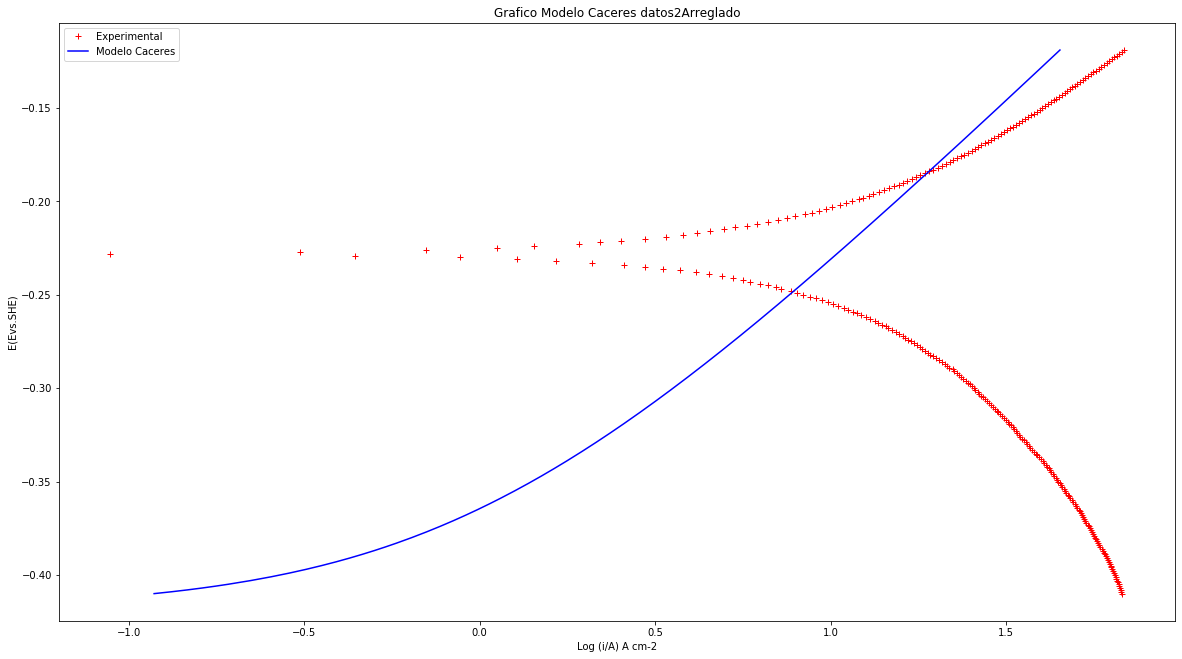

In [48]:
graficoCaceres(datosExperimentales,eVSHE,valoresModeloCaceresLog,nombreArchivo)

## Grafico de Modelo Beta

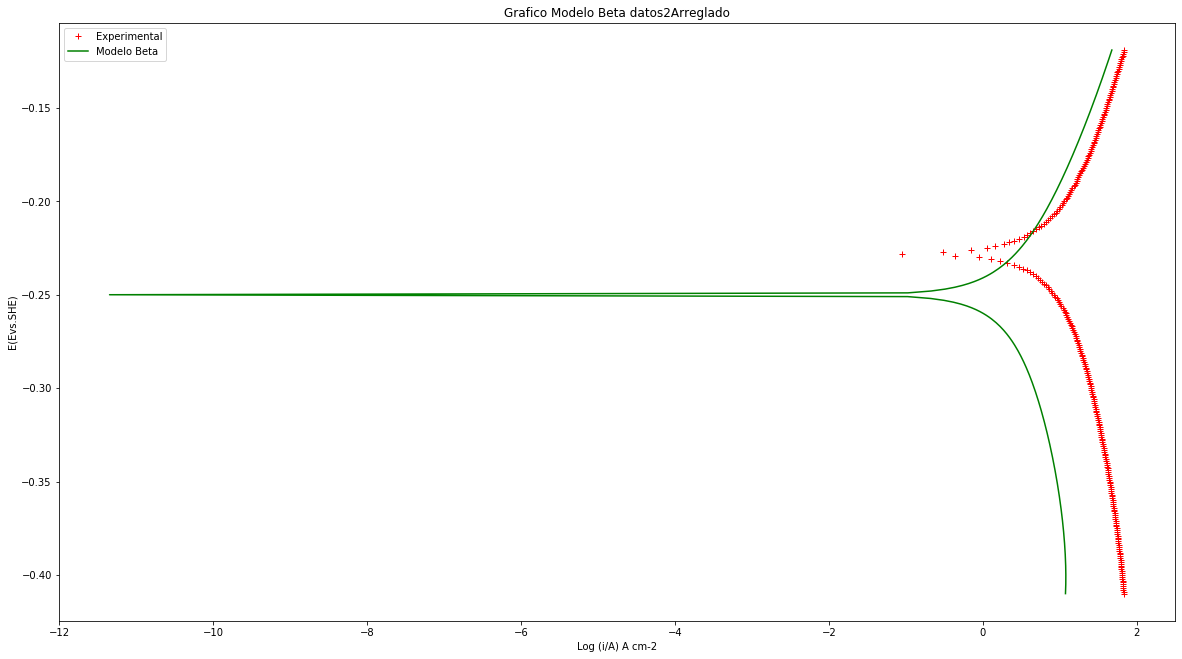

In [49]:
graficoBeta(datosExperimentales,eVSHE,valoresModeloBetaLog,nombreArchivo)

## Grafico de Modelo Maclaurin

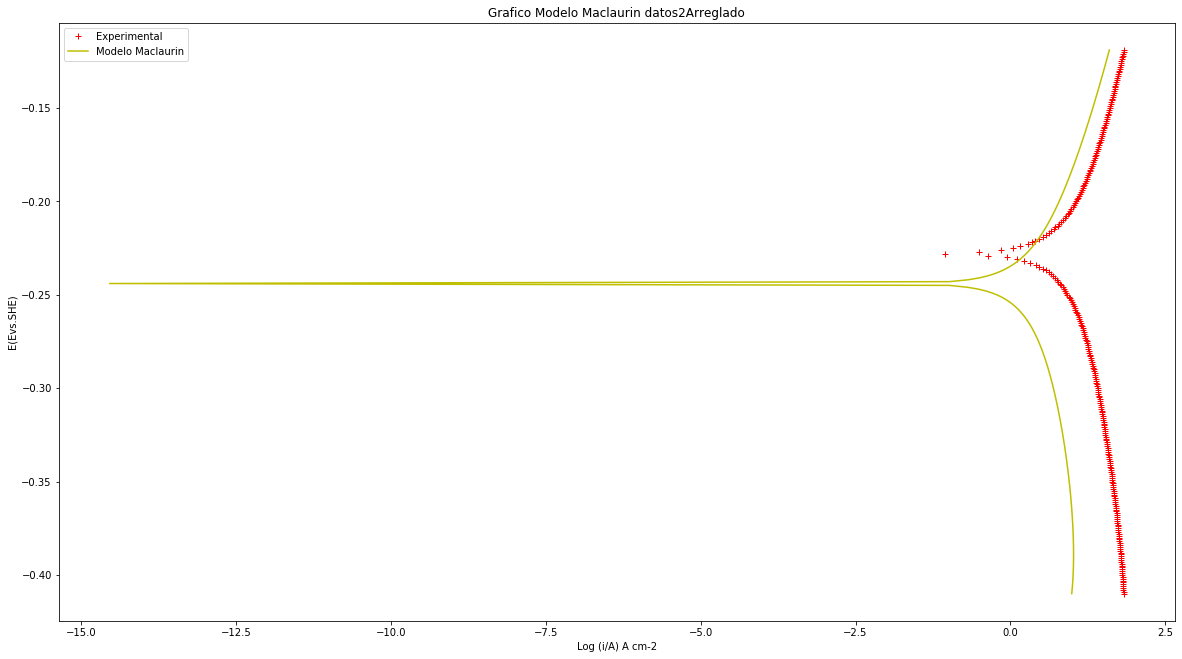

In [50]:
graficoMaclaurin(datosExperimentales,eVSHE,valoresModeloMaclaurinLog,nombreArchivo)

## Grafico de Modelo Caceres, Beta y Maclaurin

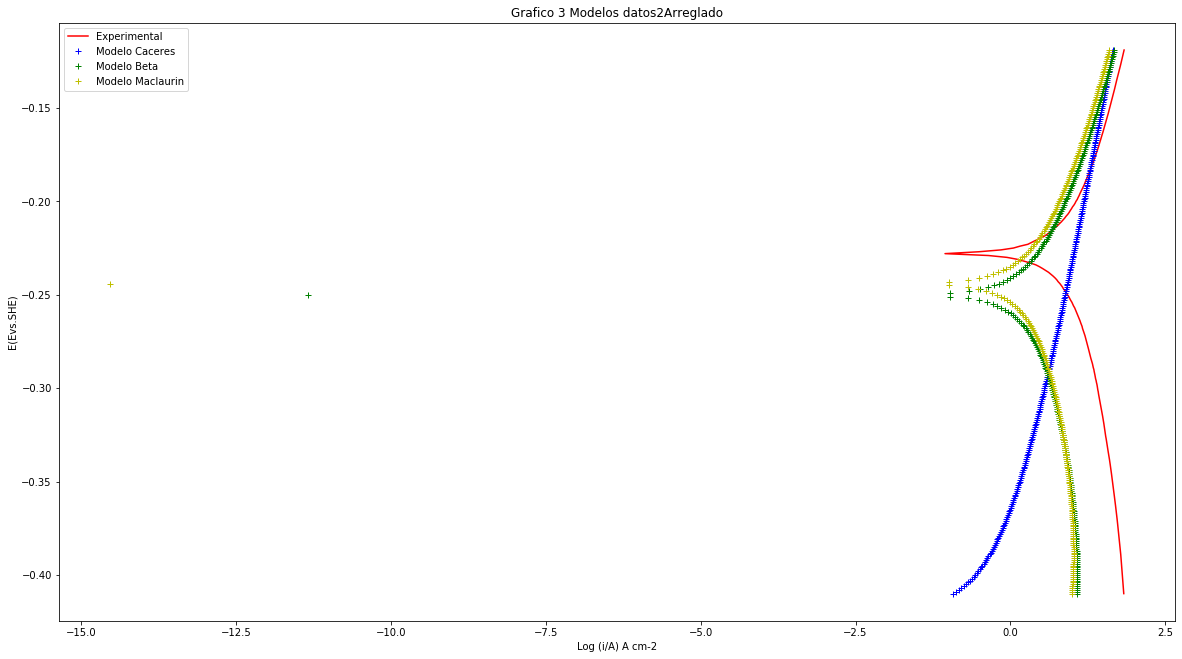

In [51]:
grafico3modelos(datosExperimentales,eVSHE,valoresModeloCaceresLog,valoresModeloBetaLog,valoresModeloMaclaurinLog,nombreArchivo)

## Tablas coeficientes optimos

### Modelo Caceres

In [52]:
datosCaceres

,"io,O2","iL,O2","ife,O2",tc,ta
Modelo Caceres,0.099344,1.0,0.082487,0.162803,0.18


### Modelo Beta y Maclaurin

In [53]:
datosBetaMaclaurin

,iCorr,Ecorr,ba,Beta,bc
Modelo Beta,3.0,-0.250,0.099614,0.04,0.18
Modelo Maclaurin,3.0,-0.244,0.104471,0.04,0.18


## Tabla Indice de Corrosion y Ratio de Corrosion de Modelo Caceres, Beta y Maclaurin

In [54]:
datosIndiceRatioCorr

,Indice de corrosion,Ratio de corrosion
Modelo Caceres,0.999994,11.623532
Modelo Beta,3.000000,34.870812
Modelo Maclaurin,3.000000,34.870812


## Tabla Estadigrafos de Modelo Caceres, Beta y Maclaurin

In [55]:
datosEstadigrafos

,SS,Promedio de Y,SEofY,R2,SSE,RMSE,Chi-Cuadrado
Modelo Caceres,2229.943805,-10.422675,148.816464,0.156215,8.267581,12.199035,7.716069
Modelo Beta,889.439174,-10.422675,141.163447,0.477326,7.842414,11.881222,3.077644
Modelo Maclaurin,1323.929080,-10.422675,139.799684,0.431625,7.766649,11.823692,4.581069
